In [6]:
import numpy as np
import pandas as pd

In [7]:
df=pd.read_csv('spam.csv', encoding='latin1', on_bad_lines='skip')

In [8]:
df.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
3007,spam,"Loan for any purpose å£500 - å£75,000. Homeown...",NaN,NaN,NaN
1023,ham,May i call You later Pls,NaN,NaN,NaN
4133,ham,Is it your yahoo boys that bring in the perf? ...,NaN,NaN,NaN
3722,ham,We left already we at orchard now.,NaN,NaN,NaN
4533,ham,I have no money 4 steve mate! !,NaN,NaN,NaN


In [9]:
df.shape

(5572, 5)

## Data Cleaning

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [11]:
# since last 3 columns are redundant, we drop them
df.drop(columns=['Unnamed: 2','Unnamed: 3', 'Unnamed: 4'], inplace=True)

In [12]:
df.sample(5)

,v1,v2
4771,ham,"Hi, Mobile no. &lt;#&gt; has added you in th..."
3811,ham,Yep then is fine 7.30 or 8.30 for ice age.
1237,ham,Is ur paper in e morn or aft tmr?
3039,ham,One day a crab was running on the sea shore..T...
5138,ham,Yup... I havent been there before... You want ...


In [13]:
df.rename(columns = {'v1':'target', 'v2':'text'}, inplace = True)
df.sample(5)

,target,text
3498,ham,I hope you arnt pissed off but id would really...
4361,ham,"I can't right this second, gotta hit people up..."
1704,ham,What can i do? Might accidant tookplace betwee...
1510,ham,"Pete,is this your phone still? Its Jenny from ..."
5208,ham,Hi.what you think about match?


In [14]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [15]:
df['target'] = encoder.fit_transform(df['target'])
df.sample(5)

,target,text
1719,0,Then u better go sleep.. Dun disturb u liao.. ...
1418,0,Lmao. Take a pic and send it to me.
150,0,The wine is flowing and i'm i have nevering..
493,0,What class of &lt;#&gt; reunion?
3060,0,What u talking bout early morning? It's almost...


In [16]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [17]:
df.isnull().sum()


target    0
text      0
dtype: int64

In [18]:
df.duplicated().sum()

np.int64(403)

In [19]:
df =df.drop_duplicates(keep='first')

In [20]:
df.shape

(5169, 2)

In [21]:
df['target'].value_counts()

target
0    4516
1     653
Name: count, dtype: int64

([<matplotlib.patches.Wedge at 0x201368fd550>,
 [Text(-1.014499732282844, 0.4251944181172162, 'ham'),
  Text(1.0144998708287172, -0.42519408755122207, 'spam')],
 [Text(-0.5533634903360967, 0.2319242280639361, '87.37'),
  Text(0.553363565906573, -0.231924047755212, '12.63')])

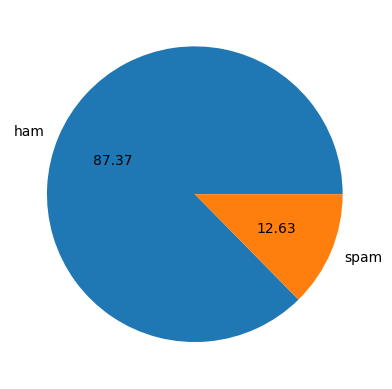

In [22]:
import matplotlib.pyplot as plt
plt.pie(df['target'].value_counts(), labels=['ham', 'spam'], autopct='%0.2f')

In [23]:
import nltk


In [24]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\nikhi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\nikhi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nikhi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
df['num_characters']= df['text'].apply(len)

In [26]:
df.head()

,target,text,num_characters
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [27]:
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))


In [28]:
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [29]:
df.head()

,target,text,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [30]:
df[['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [31]:
df[df['target']==0][['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [32]:
df[df['target']==1][['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


In [33]:
import seaborn as sns

<Axes: xlabel='num_characters', ylabel='Count'>

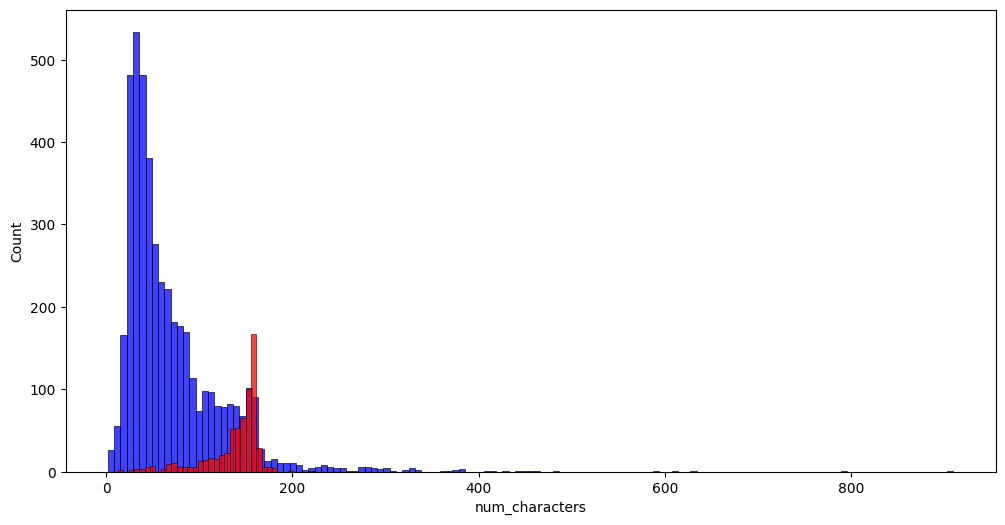

In [34]:
plt.figure(figsize=(12, 6))
sns.histplot(df[df['target']==0]['num_characters'], color='blue', label='ham')
sns.histplot(df[df['target']==1]['num_characters'], color='red')

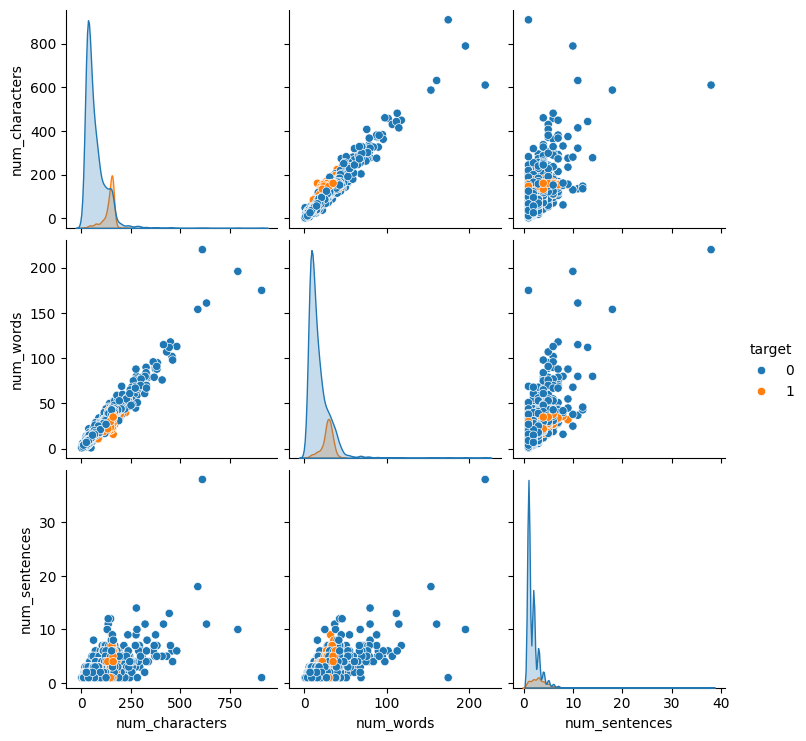

In [35]:
sns.pairplot(df,hue='target')

<Axes: >

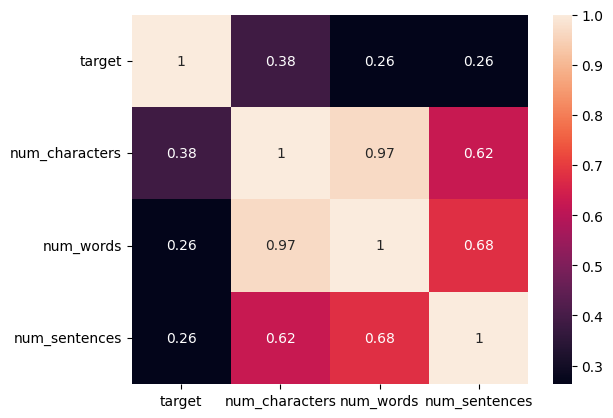

In [36]:
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True)

**Data Processing**
- Lowercase
- Tokenize
- Remove Special chars
- Removing stop words and punctuation
- Stemming

In [37]:
from nltk.corpus import stopwords
stopwords.words('english')
import string
string.punctuation
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer() 


In [38]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    y =[]
    for i in text:
        if i.isalnum():
            y.append(i)
    
    text = y[:]
    y.clear()
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    text = y[:]
    y.clear()
    for i in text:
        y.append(stemmer.stem(i))
    return " ".join(y)

In [39]:
transform_text('Hey i just saw your project you have been working on. I love it!')

'hey saw project work love'

In [40]:
df['transformed_text']=df['text'].apply(transform_text)
df.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [41]:
from wordcloud import WordCloud
wc = WordCloud(width=500, height=500, min_font_size=10, background_color='white')


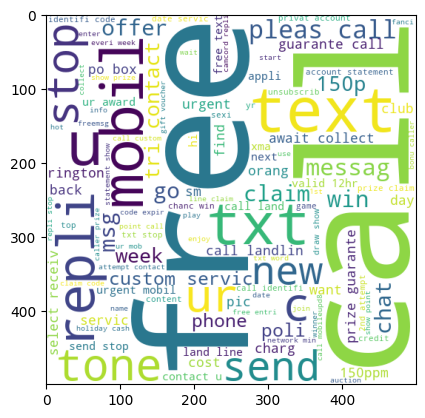

In [42]:
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))
plt.Figure(figsize=(10, 10))
plt.imshow(spam_wc)

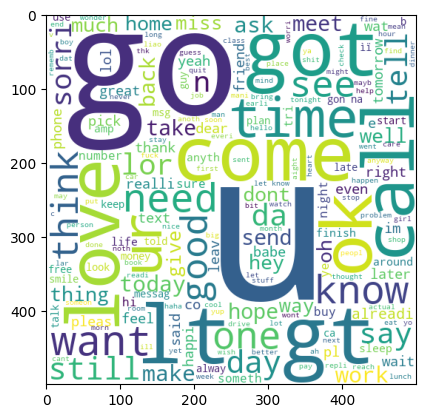

In [43]:
ham_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))
plt.Figure(figsize=(10, 10))
plt.imshow(ham_wc)

In [44]:
spam_corpus = []
for message in df[df['target']==1]['transformed_text'].to_list():
    for word in message.split():
        spam_corpus.append(word)

ham_corpus = []
for message in df[df['target']==0]['transformed_text'].to_list():
    for word in message.split():
        ham_corpus.append(word)

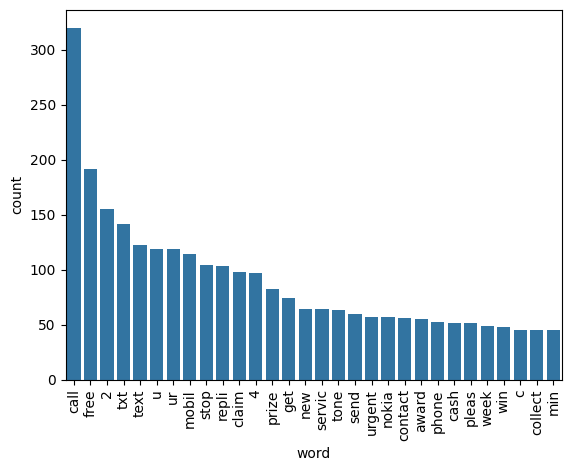

In [45]:
from collections import Counter

common_words = Counter(spam_corpus).most_common(30)
common_words_df = pd.DataFrame(common_words, columns=['word', 'count'])

sns.barplot(x='word', y='count', data=common_words_df)
plt.xticks(rotation='vertical')
plt.show()


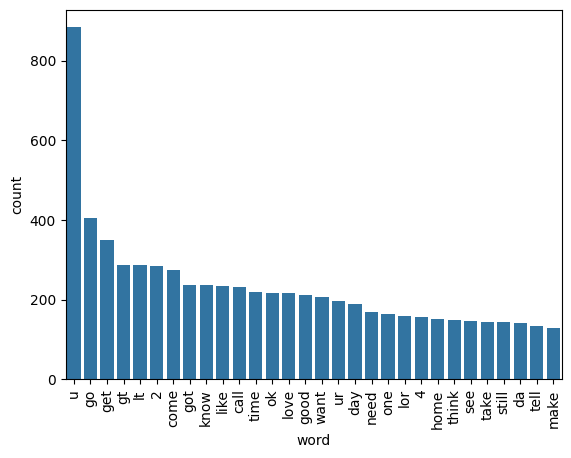

In [46]:
from collections import Counter

common_words = Counter(ham_corpus).most_common(30)
common_words_df = pd.DataFrame(common_words, columns=['word', 'count'])

sns.barplot(x='word', y='count', data=common_words_df)
plt.xticks(rotation='vertical')
plt.show()

**Model Building**

In [47]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
tfidf = TfidfVectorizer()
cv = CountVectorizer()

In [48]:
X = tfidf.fit_transform(df['transformed_text']).toarray()
y = df['target'].values

- Applying train test split

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [50]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [51]:
gnb.fit(X_train, y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test, y_pred1))
print(confusion_matrix(y_test, y_pred1))
print(precision_score(y_test, y_pred1))

0.8762088974854932
[[793 103]
 [ 25 113]]
0.5231481481481481


In [52]:
mnb.fit(X_train, y_train)
y_pred2 = mnb.predict(X_test)
print(accuracy_score(y_test, y_pred2))
print(confusion_matrix(y_test, y_pred2))
print(precision_score(y_test, y_pred2))

0.9593810444874274
[[896   0]
 [ 42  96]]
1.0


In [53]:
bnb.fit(X_train, y_train)
y_pred3 = bnb.predict(X_test)
print(accuracy_score(y_test, y_pred3))
print(confusion_matrix(y_test, y_pred3))
print(precision_score(y_test, y_pred3))

0.9700193423597679
[[893   3]
 [ 28 110]]
0.9734513274336283


In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [55]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)

In [56]:
clfs = {
    'SVC' : svc,
    'KN' : knc, 
    'NB': mnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt,
}

In [57]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    
    return accuracy,precision

In [58]:
train_classifier(svc,X_train,y_train,X_test,y_test)

(0.9729206963249516, 0.9741379310344828)

In [59]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():
    
    current_accuracy,current_precision = train_classifier(clf, X_train,y_train,X_test,y_test)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  SVC
Accuracy -  0.9729206963249516
Precision -  0.9741379310344828
For  KN
Accuracy -  0.9003868471953579
Precision -  1.0
For  NB
Accuracy -  0.9593810444874274
Precision -  1.0
For  DT
Accuracy -  0.937137330754352
Precision -  0.8543689320388349
For  LR
Accuracy -  0.9516441005802708
Precision -  0.94
For  RF
Accuracy -  0.971953578336557
Precision -  1.0
For  AdaBoost
Accuracy -  0.9245647969052224
Precision -  0.8409090909090909
For  BgC
Accuracy -  0.9584139264990329
Precision -  0.8625954198473282
For  ETC
Accuracy -  0.9729206963249516
Precision -  0.9824561403508771
For  GBDT
Accuracy -  0.9526112185686654
Precision -  0.9238095238095239


In [61]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)
performance_df


,Algorithm,Accuracy,Precision
1,KN,0.900387,1.000000
2,NB,0.959381,1.000000
5,RF,0.971954,1.000000
8,ETC,0.972921,0.982456
0,SVC,0.972921,0.974138
4,LR,0.951644,0.940000
9,GBDT,0.952611,0.923810
7,BgC,0.958414,0.862595
3,DT,0.937137,0.854369
6,AdaBoost,0.924565,0.840909


In [62]:
performance_df1 = pd.melt(performance_df, id_vars = "Algorithm")
performance_df1

,Algorithm,variable,value
0,KN,Accuracy,0.900387
1,NB,Accuracy,0.959381
2,RF,Accuracy,0.971954
3,ETC,Accuracy,0.972921
4,SVC,Accuracy,0.972921
5,LR,Accuracy,0.951644
6,GBDT,Accuracy,0.952611
7,BgC,Accuracy,0.958414
8,DT,Accuracy,0.937137
9,AdaBoost,Accuracy,0.924565


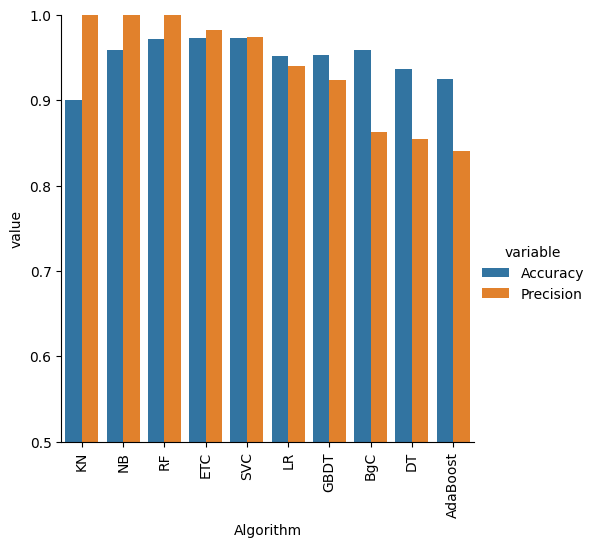

In [63]:
sns.catplot(x = 'Algorithm', y='value', 
               hue = 'variable',data=performance_df1, kind='bar',height=5)
plt.ylim(0.5,1.0)
plt.xticks(rotation='vertical')
plt.show()

fine tuning


In [64]:
temp_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy_scaling':accuracy_scores,'Precision_scaling':precision_scores}).sort_values('Precision_scaling',ascending=False)
new_df = performance_df.merge(temp_df,on='Algorithm')
new_df_scaled = new_df.merge(temp_df,on='Algorithm')
temp_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy_num_chars':accuracy_scores,'Precision_num_chars':precision_scores}).sort_values('Precision_num_chars',ascending=False)
new_df_scaled.merge(temp_df,on='Algorithm')



,Algorithm,Accuracy,Precision,Accuracy_scaling_x,Precision_scaling_x,Accuracy_scaling_y,Precision_scaling_y,Accuracy_num_chars,Precision_num_chars
0,KN,0.900387,1.000000,0.900387,1.000000,0.900387,1.000000,0.900387,1.000000
1,NB,0.959381,1.000000,0.959381,1.000000,0.959381,1.000000,0.959381,1.000000
2,RF,0.971954,1.000000,0.971954,1.000000,0.971954,1.000000,0.971954,1.000000
3,ETC,0.972921,0.982456,0.972921,0.982456,0.972921,0.982456,0.972921,0.982456
4,SVC,0.972921,0.974138,0.972921,0.974138,0.972921,0.974138,0.972921,0.974138
5,LR,0.951644,0.940000,0.951644,0.940000,0.951644,0.940000,0.951644,0.940000
6,GBDT,0.952611,0.923810,0.952611,0.923810,0.952611,0.923810,0.952611,0.923810
7,BgC,0.958414,0.862595,0.958414,0.862595,0.958414,0.862595,0.958414,0.862595
8,DT,0.937137,0.854369,0.937137,0.854369,0.937137,0.854369,0.937137,0.854369
9,AdaBoost,0.924565,0.840909,0.924565,0.840909,0.924565,0.840909,0.924565,0.840909


In [65]:
# Voting Classifier
svc = SVC(kernel='sigmoid', gamma=1.0,probability=True)
mnb = MultinomialNB()
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)

from sklearn.ensemble import VotingClassifier

In [66]:
voting = VotingClassifier(estimators=[('svm', svc), ('nb', mnb), ('et', etc)],voting='soft')
voting.fit(X_train,y_train)


,estimators,"[('svm', ...), ('nb', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,C,1.0
,kernel,'sigmoid'
,degree,3
,gamma,1.0
,coef0,0.0


In [67]:
y_pred = voting.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.9787234042553191
Precision 1.0


In [68]:
# Applying stacking
estimators=[('svm', svc), ('nb', mnb), ('et', etc)]
final_estimator=RandomForestClassifier()

In [71]:
from sklearn.ensemble import StackingClassifier
clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)


In [72]:
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.9816247582205029
Precision 0.9612403100775194
